# Proyecto Final MAT281 - Aplicaciones de la Matemática en Ingeniería


Integrantes:
*   Antonio Aguilar Lolas
*   Nicolás Lara Guerra
* Cristopher Martínez Sánchez
* Rodrigo Montecinos Aravena
* Diego Sandoval Jara

<img src="https://media.istockphoto.com/id/873586578/es/foto/silueta-de-la-antena.jpg?s=612x612&w=0&k=20&c=JRg_eqI3yfDJ9f5JCJw3pSqpkONj6LSMEP_DHQ5F2DY=" width="400"  align="center"/>



## 1. Definición del problema

En la industria de las telecomunicaciones, el “churn” o deserción de clientes se refiere a la pérdida de usuarios que deciden terminar su relación con la empresa o cambiarse a otro proveedor. En mercados altamente competitivos, donde cambiar de compañía suele ser sencillo y los servicios se perciben como similares, el churn se vuelve un problema estratégico: **adquirir un nuevo cliente suele ser varias veces más costoso que retener a uno existente**, por lo que una alta tasa de abandono impacta directamente en los ingresos y en la rentabilidad de largo plazo.

En este proyecto utilizaremos el dataset “Telco Customer Churn”, derivado de datos de una compañía de telecomunicaciones ficticia. Cada fila representa un cliente y las columnas describen sus características demográficas (por ejemplo, género o presencia de dependientes), los servicios contratados (telefonía, internet, seguridad, respaldo, streaming, soporte técnico, etc.), información de su cuenta (antigüedad, tipo de contrato, método de pago, cargos mensuales y totales) y una etiqueta que indica si el cliente se fue o permaneció con la empresa (Churn).

El objetivo central del proyecto es construir y analizar modelos de Machine Learning capaces de predecir la probabilidad de churn de cada cliente, a partir de sus características y comportamiento registrado en el dataset. Técnicamente, se trata de un problema de **clasificación binaria supervisada** donde la variable objetivo es:

* `Churn` = 1 (o "Yes"): el cliente abandonó la compañía.

* `Churn` = 0 (o "No"): el cliente se mantuvo en la compañía.

El propósito no es solo alcanzar un buen desempeño predictivo, sino también interpretar el modelo para identificar qué factores se asocian con una mayor probabilidad de abandono (por ejemplo, ciertos tipos de contrato, niveles de cargos mensuales o combinaciones de servicios), siguiendo la línea de trabajos previos de predicción de churn que combinan modelos de clasificación e interpretabilidad para apoyar decisiones comerciales.

Desde la perspectiva del negocio, un modelo de churn bien calibrado permite priorizar campañas de retención sobre los clientes con mayor riesgo, diseñar ofertas personalizadas y optimizar la relación entre el costo de adquisición y el valor de vida del cliente, contribuyendo a una gestión más eficiente de la base de usuarios.

## 2. Análisis exploratorio


In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import (
    accuracy_score,
    precision_score,
    recall_score,
    f1_score,
    roc_auc_score,
    confusion_matrix,
    roc_curve
)
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV, StratifiedKFold
from xgboost import XGBClassifier
!pip install -q --upgrade shap
import shap
sns.set(style="whitegrid")

### Carga de DataSet
Primero, cargamos el dataset de Telco Customer Churn, disponible en la página de Kaggle: https://www.kaggle.com/datasets/blastchar/telco-customer-churn/data

In [2]:
# Ajusta la ruta / nombre del archivo
DATA_PATH = "/content/WA_Fn-UseC_-Telco-Customer-Churn.xls"

df = pd.read_csv(DATA_PATH)

print("Dimensiones del dataset (filas, columnas):")
print(df.shape)

print("\nPrimeras 5 filas del dataset:")
display(df.head())

Dimensiones del dataset (filas, columnas):
(7043, 21)

Primeras 5 filas del dataset:


,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,...,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,7590-VHVEG,Female,0,Yes,No,1,No,No phone service,DSL,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,No
1,5575-GNVDE,Male,0,No,No,34,Yes,No,DSL,Yes,...,Yes,No,No,No,One year,No,Mailed check,56.95,1889.5,No
2,3668-QPYBK,Male,0,No,No,2,Yes,No,DSL,Yes,...,No,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,Yes
3,7795-CFOCW,Male,0,No,No,45,No,No phone service,DSL,Yes,...,Yes,Yes,No,No,One year,No,Bank transfer (automatic),42.30,1840.75,No
4,9237-HQITU,Female,0,No,No,2,Yes,No,Fiber optic,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,70.70,151.65,Yes


El dataset tiene 21 columnas. A continuación, se describen algunas de ellas:

| Variable | Descripción |
|-|-|
|Churn| Si el cliente abandonó o no (Yes, No)|
|customerID| ID de cliente|
|gender| Ya sea que el cliente sea hombre o mujer (Male, Female)|
|SeniorCitizen | Si el cliente es una persona mayor o no (1, 0)|
|Partner | Si el cliente tiene o no una pareja (Yes, No)|
|Dependents | Si el cliente tiene personas a su cargo o no (Yes, No)|
|tenure| Número de meses que el cliente ha permanecido con la empresa|
|PhoneService| Si el cliente tiene servicio telefónico o no (Yes, No)|
|MultipleLines|Si el cliente tiene varias líneas o no (Yes, No, No phone service)|
|InternetService| Proveedor de servicios de internet del cliente (DSL, Fiber optic, No)|
|OnlineSecurity|Si el cliente dispone o no de seguridad en línea (Yes, No, No internet service)|
|PaymentMethod| El método de pago del cliente: cheque electrónico (Electronic check), cheque enviado por correo (Mailed check), transferencia bancaria automática (Bank transfer automatic), tarjeta de crédito automática (Credit card automatic)|
|MonthlyCharges|El importe cobrado al cliente mensualmente|
|TotalCharges|El importe total cargado al cliente|

### Estadística descriptiva

In [3]:
print("\nInformación general del DataFrame (df.info()):")
df.info()

print("\nDescripción estadística de variables numéricas:")
display(df.describe())

print("\nDescripción estadística de variables categóricas:")
display(df.describe(include="object"))



Información general del DataFrame (df.info()):
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 21 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   customerID        7043 non-null   object 
 1   gender            7043 non-null   object 
 2   SeniorCitizen     7043 non-null   int64  
 3   Partner           7043 non-null   object 
 4   Dependents        7043 non-null   object 
 5   tenure            7043 non-null   int64  
 6   PhoneService      7043 non-null   object 
 7   MultipleLines     7043 non-null   object 
 8   InternetService   7043 non-null   object 
 9   OnlineSecurity    7043 non-null   object 
 10  OnlineBackup      7043 non-null   object 
 11  DeviceProtection  7043 non-null   object 
 12  TechSupport       7043 non-null   object 
 13  StreamingTV       7043 non-null   object 
 14  StreamingMovies   7043 non-null   object 
 15  Contract          7043 non-null   object 

,SeniorCitizen,tenure,MonthlyCharges
count,7043.000000,7043.000000,7043.000000
mean,0.162147,32.371149,64.761692
std,0.368612,24.559481,30.090047
min,0.000000,0.000000,18.250000
25%,0.000000,9.000000,35.500000
50%,0.000000,29.000000,70.350000
75%,0.000000,55.000000,89.850000
max,1.000000,72.000000,118.750000



Descripción estadística de variables categóricas:


,customerID,gender,Partner,Dependents,PhoneService,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,TotalCharges,Churn
count,7043,7043,7043,7043,7043,7043,7043,7043,7043,7043,7043,7043,7043,7043,7043,7043,7043,7043
unique,7043,2,2,2,2,3,3,3,3,3,3,3,3,3,2,4,6531,2
top,3186-AJIEK,Male,No,No,Yes,No,Fiber optic,No,No,No,No,No,No,Month-to-month,Yes,Electronic check,,No
freq,1,3555,3641,4933,6361,3390,3096,3498,3088,3095,3473,2810,2785,3875,4171,2365,11,5174


Podemos observar varios puntos:
* A priori, no hay datos faltantes, pues todas las columnas tienen 7043 datos no nulos, que corresponder a la cantidad de datos.
* No hay IDs de cliente repetidos, lo cual tiene sentido.
* Las variables categóricas tienen la cantidad esperada de datos únicos (por ejemplo, gender solo toma dos valores, Male o Female).
* Hay un 16% de clientes de la tercera edad.
* El promedio de permanencia en la compañía son 32 meses.
* Problema: La variable `TotalCharges` aparece como categórica cuando debería ser numérica.
* Problema: El valor que más se repite en `TotalCharges` es el string espacio `" "`, lo cual representa un valor faltante.

In [4]:
target_col = "Churn"

print(f"\nDistribución de la variable objetivo '{target_col}':")
churn_counts = df[target_col].value_counts(dropna=False)
churn_ratio = df[target_col].value_counts(normalize=True, dropna=False)

distrib_churn = pd.DataFrame({
    "conteo": churn_counts,
    "proporción": churn_ratio
})
display(distrib_churn)


Distribución de la variable objetivo 'Churn':


,conteo,proporción
Churn,,
No,5174,0.73463
Yes,1869,0.26537


No hay igual proporción en el `Churn`. Esto puede generar un sesgo hacia las personas que no han abandonado la compañía.

### Distribución de variables numéricas

<Figure size 1400x800 with 0 Axes>

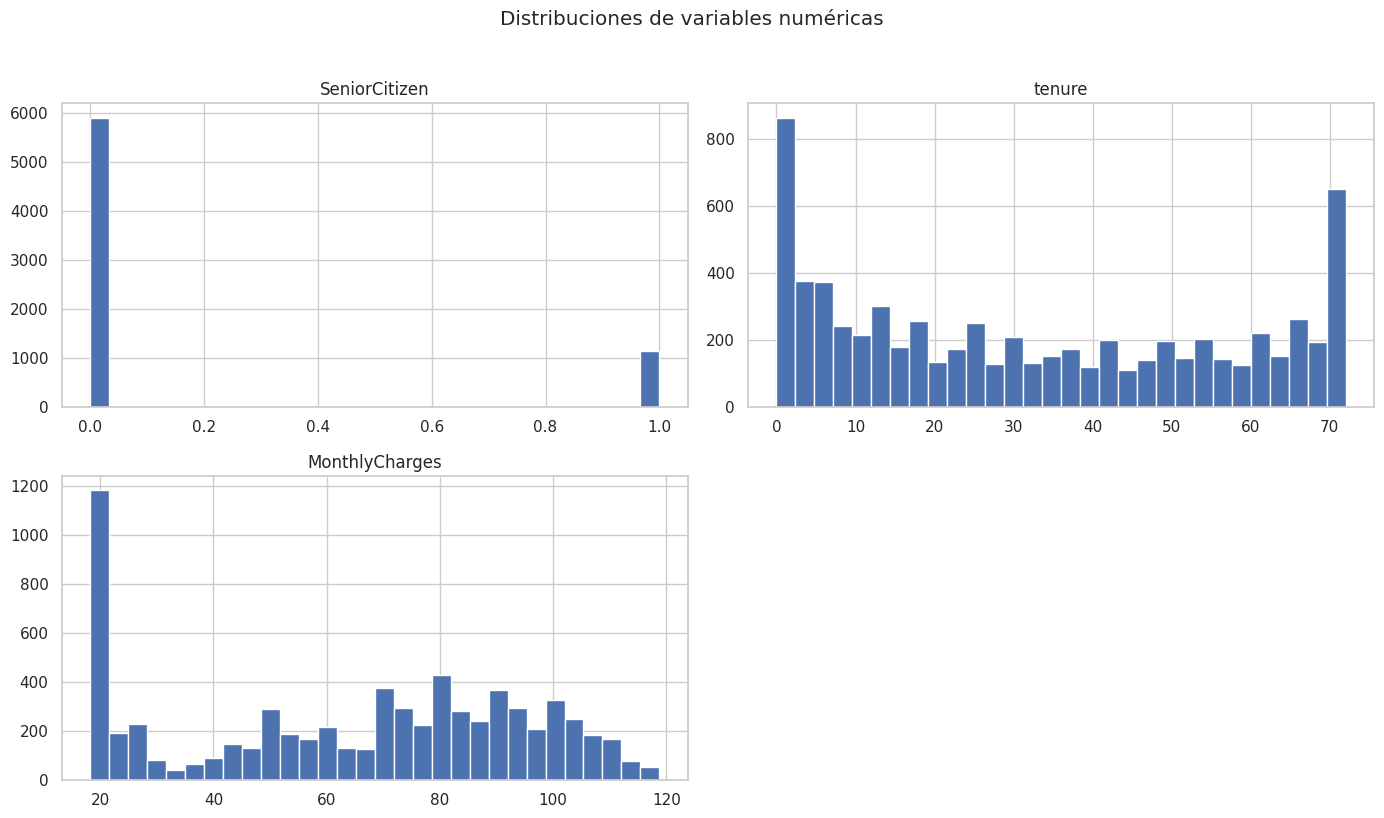

In [5]:
numeric_cols = ["SeniorCitizen", "tenure", "MonthlyCharges"]
plt.figure(figsize=(14, 8))
df[numeric_cols].hist(bins=30, figsize=(14, 8))
plt.suptitle("Distribuciones de variables numéricas", y=1.02)
plt.tight_layout()
plt.show()

Podemos ver que:
* SeniorCitizen está fuertemente desbalanceada. Esto implica que “ser adulto mayor” es una característica minoritaria en el dataset.
* tenure tiene estructura tipo "U": muchos muy nuevos y muchos muy antiguos, pocos en el medio. Más adelante, deberíamos analizar si el churn se concentra en los recién llegados o en quienes llevan más tiempo
* MonthlyCharges posee una estructura de precios diversa y con una gran cantidad de clientes con el plan de precio mínimo. Sería interesante ver si los clientes con el plan mínimo son los que abandonan más (porque perciben poco valor) o los que abandonan menos (porque valoran pagar lo mínimo).

### Correlaciones

In [6]:
corr_matrix = df[numeric_cols].corr()
corr_matrix

,SeniorCitizen,tenure,MonthlyCharges
SeniorCitizen,1.000000,0.016567,0.220173
tenure,0.016567,1.000000,0.247900
MonthlyCharges,0.220173,0.247900,1.000000


A priori, no se ve multicolinealidad.

## 3. Visualización descriptiva

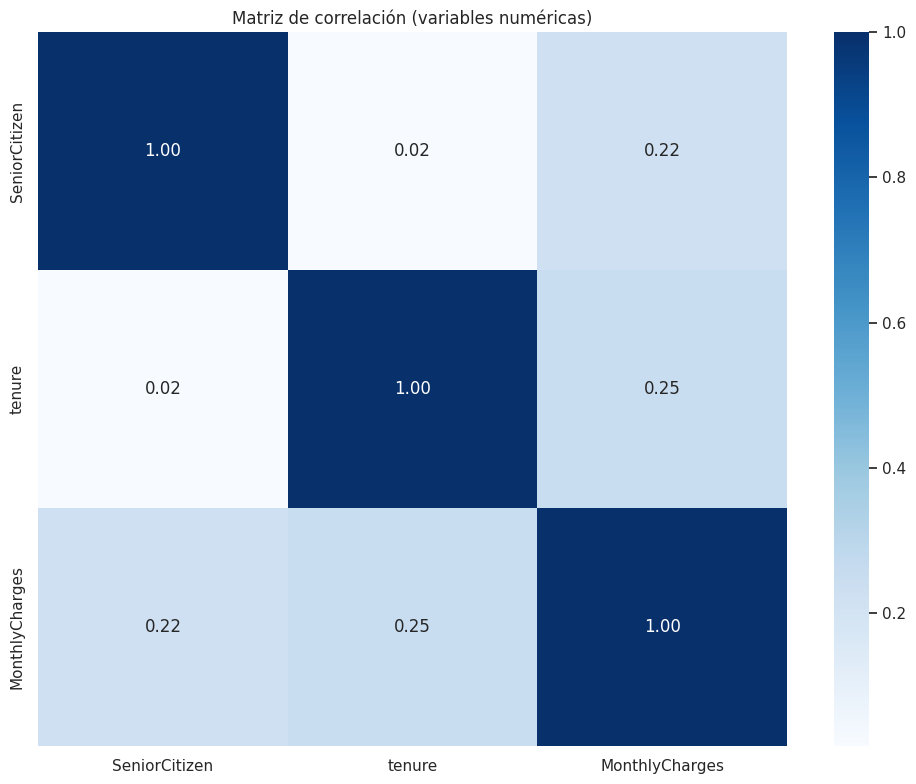

In [7]:
if len(numeric_cols) > 0:
    plt.figure(figsize=(10, 8))
    corr_matrix = df[numeric_cols].corr()
    sns.heatmap(corr_matrix, annot=True, fmt=".2f", cmap="Blues")
    plt.title("Matriz de correlación (variables numéricas)")
    plt.tight_layout()
    plt.show()
else:
    print("No se encontraron columnas numéricas para calcular correlaciones.")

No parece haber multicolinealidad. Hay que esperar a transformar `TotalCharges` a variable numérica para medir su grado de correlación con las demás variables.

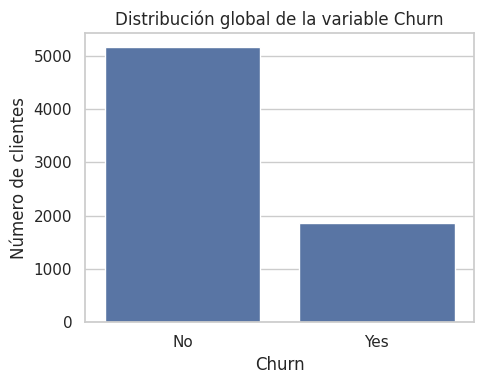

In [8]:
# Distribución general de Churn
plt.figure(figsize=(5, 4))
sns.countplot(data=df, x=target_col)
plt.title("Distribución global de la variable Churn")
plt.xlabel("Churn")
plt.ylabel("Número de clientes")
plt.tight_layout()
plt.show()

La mayoría de los clientes pertenece a la clase "No" (no churn), mientras que una fracción bastante menor está en la clase "Yes" (churn). Esto indica que el dataset está **desbalanceado**: hay muchos más clientes que se quedan que clientes que se van.

Como consecuencia, un modelo que siempre predijera "No" tendría una accuracy alta, pero sería inútil para detectar abandono. Por eso, más adelante será importante usar técnicas de balanceo como pesos de clase o SMOTE.

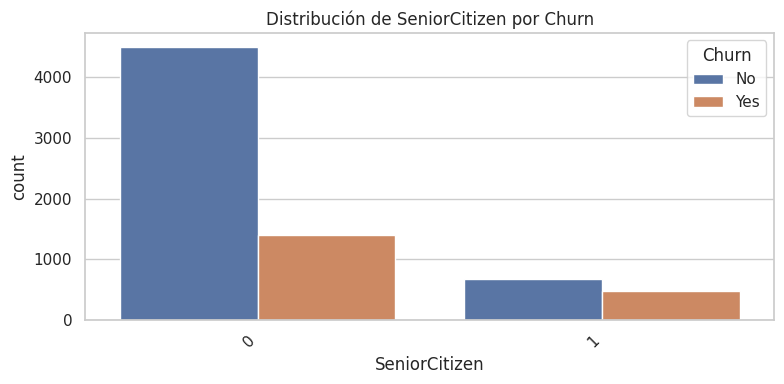

In [9]:
plt.figure(figsize=(8, 4))
sns.countplot(data=df, x="SeniorCitizen", hue=target_col)
plt.title(f"Distribución de SeniorCitizen por {target_col}")
plt.xticks(rotation=45, ha="right")
plt.tight_layout()
plt.show()

La gran mayoría de los clientes tiene `SeniorCitizen = 0` (no son adultos mayores). El grupo `SeniorCitizen = 1` es mucho más pequeño.

Aunque el grupo de adultos mayores es pequeño, la altura de la barra naranja ("Yes") está relativamente cerca a la azul en este grupo. Sería interesante ver la tasa de churn, pues esto sugiere que esta tasa es mayor entre los adultos mayores que entre los no adultos mayores.

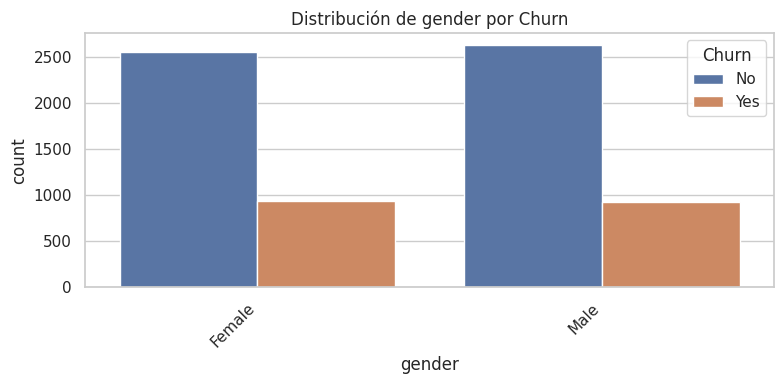

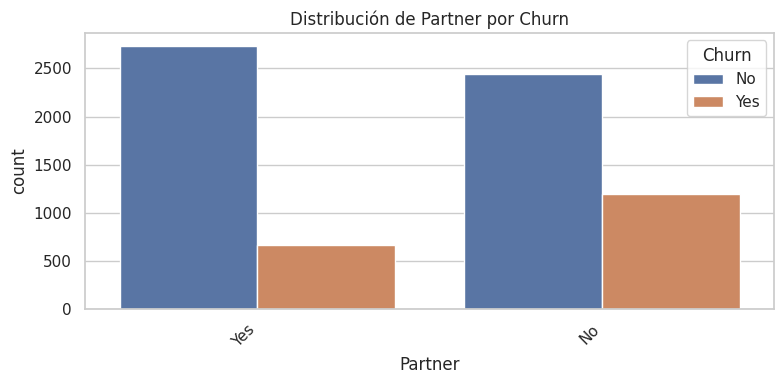

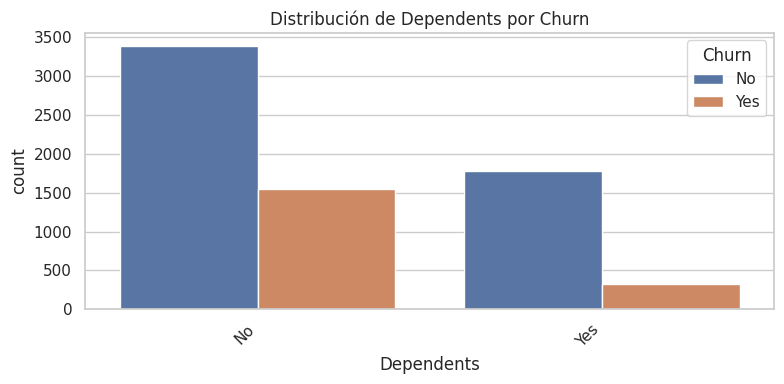

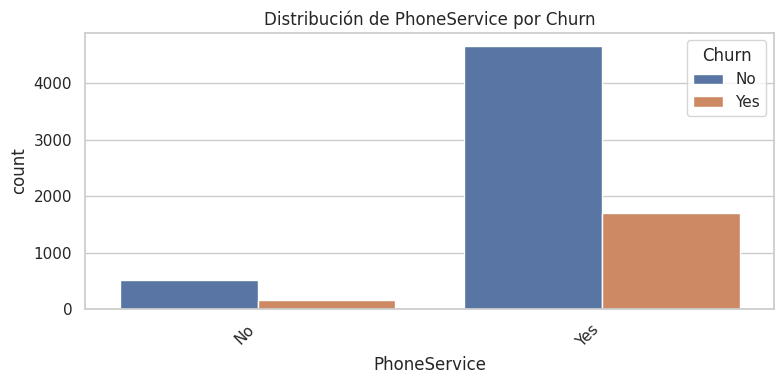

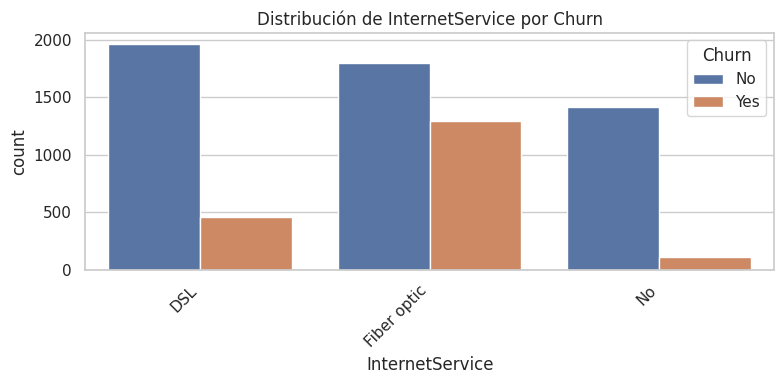

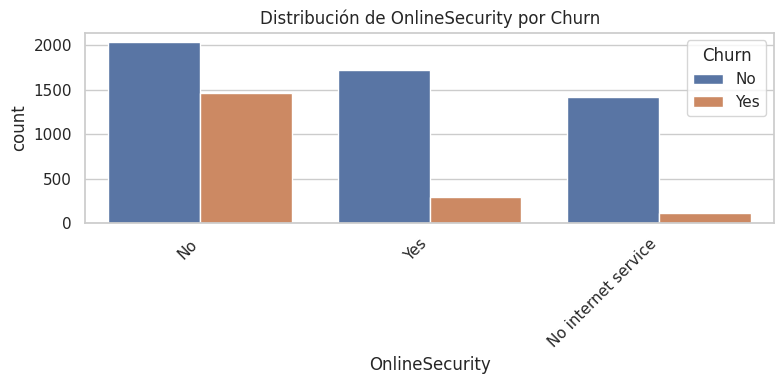

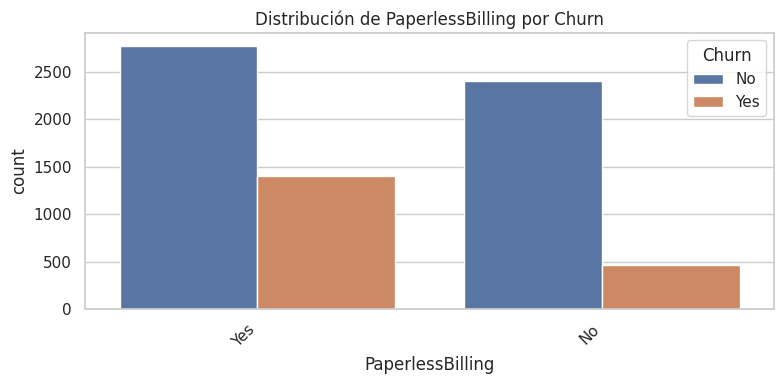

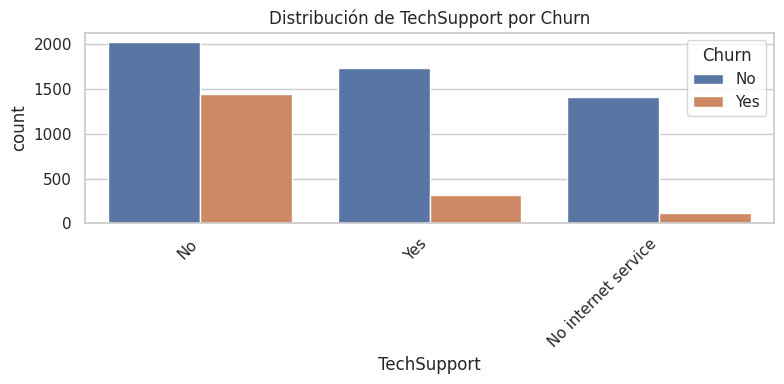

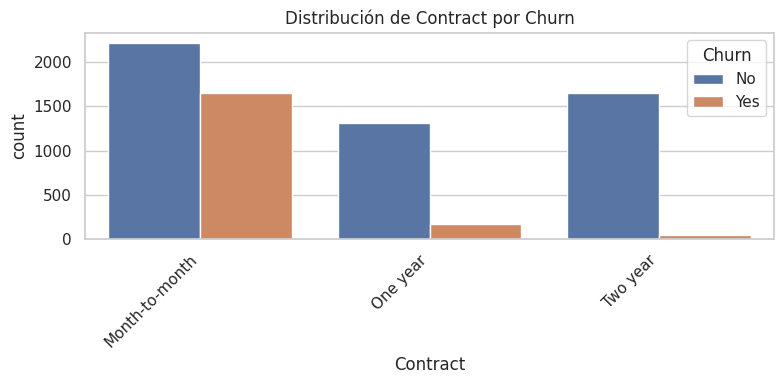

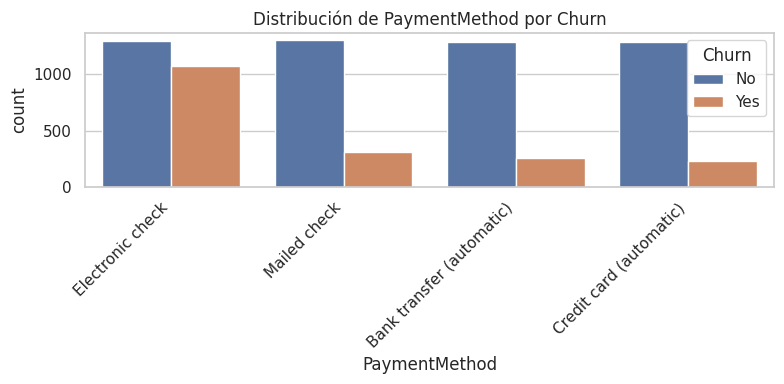

In [10]:
# Algunas variables categóricas típicas del dataset (se filtran por si no existen)
vars_cat_clave = [
    "gender",
    "Partner",
    "Dependents",
    "PhoneService",
    "InternetService",
    "OnlineSecurity",
    "PaperlessBilling",
    "TechSupport",
    "Contract",
    "PaymentMethod"
]

for col in vars_cat_clave:
    plt.figure(figsize=(8, 4))
    sns.countplot(data=df, x=col, hue=target_col)
    plt.title(f"Distribución de {col} por {target_col}")
    plt.xticks(rotation=45, ha="right")
    plt.tight_layout()
    plt.show()

Notemos que casi todos los clientes tienen servicio telefónico, por lo que esta variable por sí sola no parece muy discriminativa.

Veremos la "**tasa de churn por categoría**" que es, básicamente, la proporción de clientes que se van dentro de cada grupo/categoría de una variable.

Formalmente, para una variable categórica `col` y una categoría concreta `c`:
$$ \text{tasa de churn en la categoría c}= \frac{\#\{\text{clientes con col}=\text{c y Churn}= \text{Yes}\}}{\#\{\text{clientes con col}=\text{c}\}} $$

Esta tasa nos dice qué tan riesgosa es cada categoría, independientemente de cuántos clientes haya en ella.

In [11]:
def plot_churn_rate_bar(df, col, target_col="Churn"):
    """
    Calcula y grafica la tasa de churn por categoría de la columna 'col'.
    """
    tabla = (
        df.groupby(col)[target_col]
        .value_counts(normalize=True)
        .rename("proporcion")
        .reset_index()
    )
    # Nos quedamos solo con la proporción de Churn = 'Yes' (o 1) como tasa de churn
    clase_positiva = df[target_col].unique()[0]
    # si la variable es Yes/No, fijamos explícitamente "Yes"
    if set(df[target_col].unique()) >= {"Yes", "No"}:
        clase_positiva = "Yes"

    tabla_churn = tabla[tabla[target_col] == clase_positiva]
    plt.figure(figsize=(6, 4))
    sns.barplot(data=tabla_churn, x=col, y="proporcion")
    plt.title(f"Tasa de churn por categoría de {col}")
    plt.ylabel("Tasa de churn")
    plt.xlabel(col)
    plt.ylim(0, 1)
    plt.xticks(rotation=45, ha="right")
    plt.tight_layout()
    plt.show()

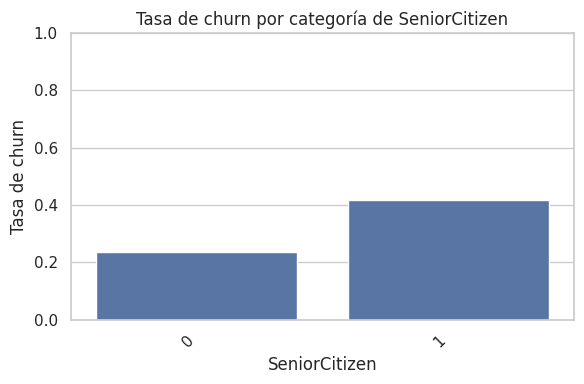

In [12]:
plot_churn_rate_bar(df, "SeniorCitizen", target_col=target_col)

Efectivamente, la tasa de churn es mayor entre los adultos mayores que entre los no adultos mayores.

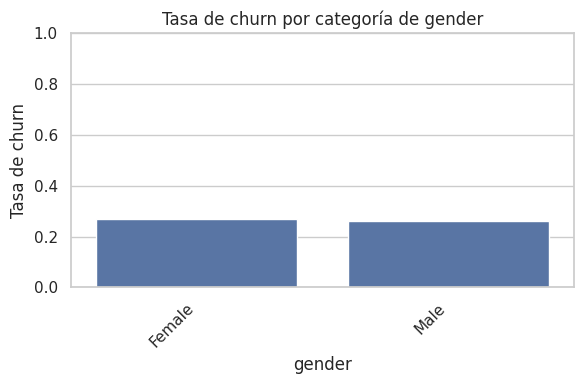

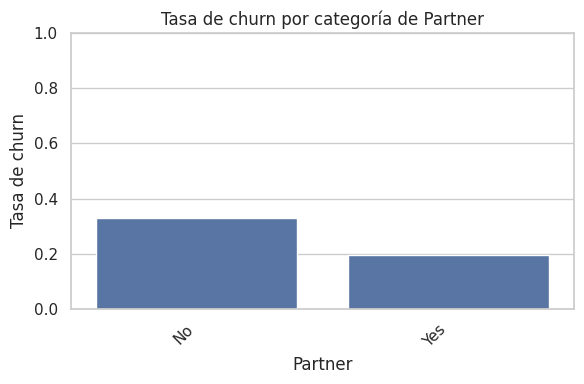

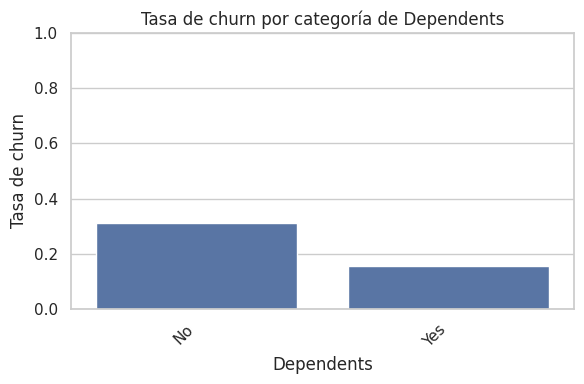

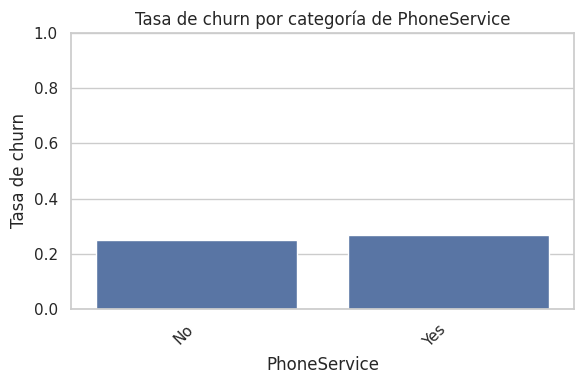

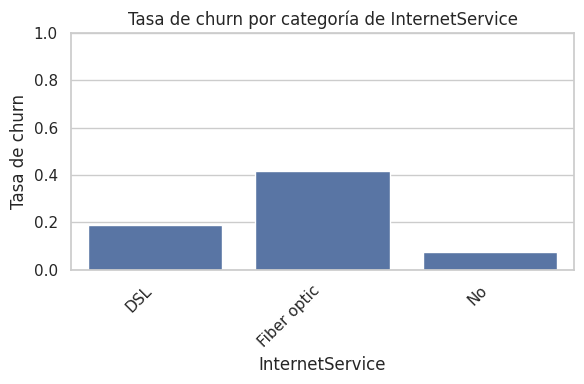

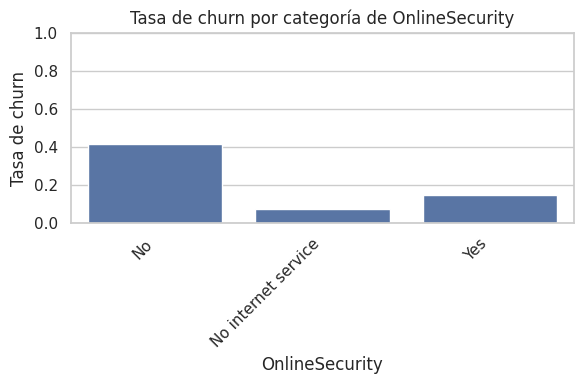

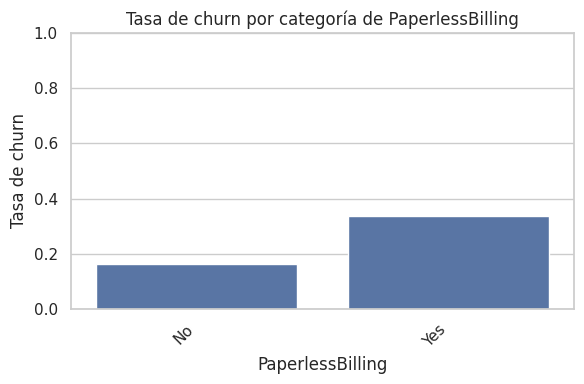

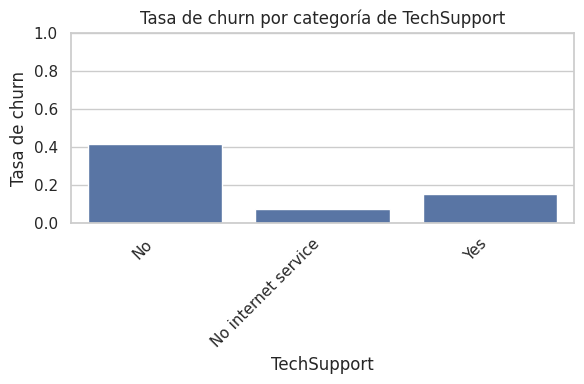

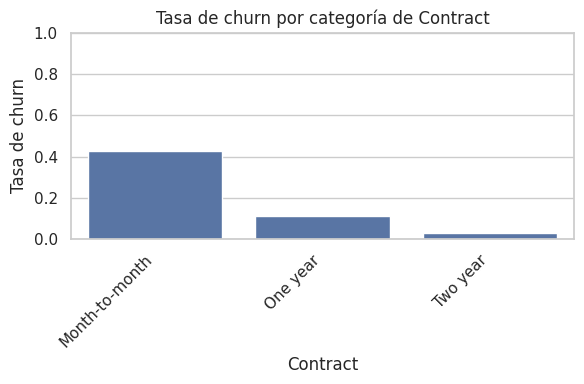

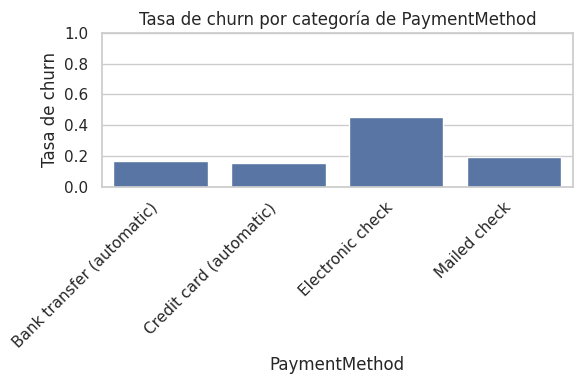

In [13]:
vars_cat_clave = [
    "gender",
    "Partner",
    "Dependents",
    "PhoneService",
    "InternetService",
    "OnlineSecurity",
    "PaperlessBilling",
    "TechSupport",
    "Contract",
    "PaymentMethod"
]

for col in vars_cat_clave:
    # barra con tasa de churn
    plot_churn_rate_bar(df, col, target_col=target_col)

Podemos ver que:
* No se ve una diferencia fuerte entre hombres y mujeres en términos del churn.
* Partner / Dependents: tener pareja y/o dependientes parece estar asociado con menor churn.
* No se ve una diferencia fuerte entre clientes con o sin servicio telefónico.
* Los clientes con Fibra óptica muestran una cantidad de churn "Yes" relativamente alta en comparación con los que tienen DSL o incluso con los que no tienen servicio de Internet. Podría indicar problemas de satisfacción o de precio en ese segmento.
* Los clientes de Internet que no cuentan con soporte técnico parecen ser más propensos a abandonar que aquellos que sí tienen soporte.
* La ausencia de servicios de seguridad en línea se asocia con una mayor probabilidad de abandono.
* Hay más clientes que hacen churn en el grupo con facturación electrónica que en el grupo sin ella. Esto sugiere que la tasa de churn es más alta entre quienes usan *paperless billing* que entre quienes reciben boletas físicas.
* Los contratos Month-to-month concentran la mayor parte del churn. Parece que los contratos de largo plazo "amarran" al cliente y reducen la probabilidad de salida.
* El método Electronic check destaca con una barra de churn "Yes" mucho más grande que el resto.

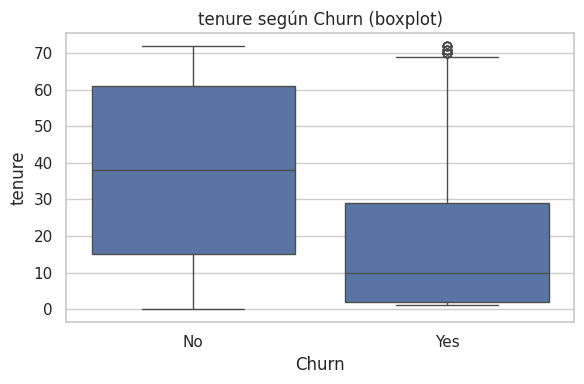

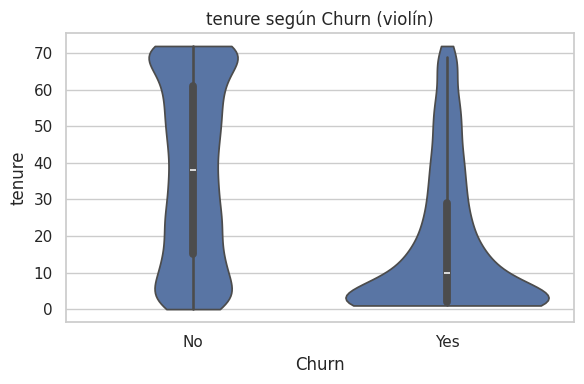

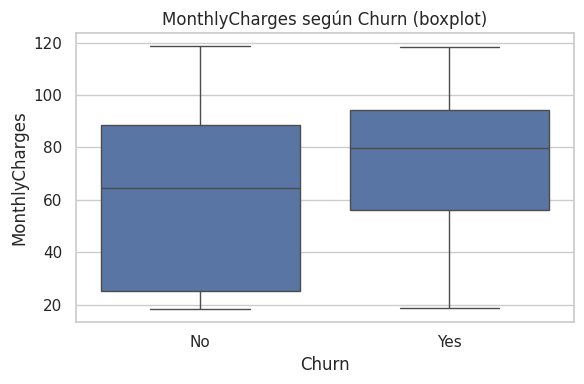

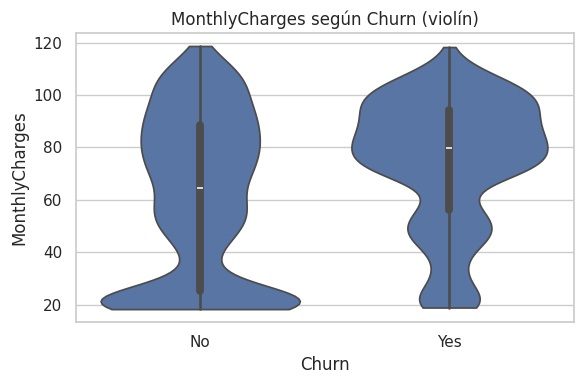

In [14]:
vars_num_clave_posibles = ["tenure", "MonthlyCharges", "TotalCharges"]
vars_num_clave = [v for v in vars_num_clave_posibles if v in numeric_cols]

for col in vars_num_clave:
    plt.figure(figsize=(6, 4))
    sns.boxplot(data=df, x=target_col, y=col)
    plt.title(f"{col} según {target_col} (boxplot)")
    plt.tight_layout()
    plt.show()

    plt.figure(figsize=(6, 4))
    sns.violinplot(data=df, x=target_col, y=col, cut=0)
    plt.title(f"{col} según {target_col} (violín)")
    plt.tight_layout()
    plt.show()

De los gráficos de caja y violín, podemos inferir que:
* Los clientes que no hacen churn tienen una mediana de antigüedad bastante alta y un rango amplio que cubre muchos meses.

* Los clientes que sí hacen churn, quienes concentran su distribución en antigüedades bajas. Por tanto, los clientes recién incorporados son mucho más propensos a irse; una vez que el cliente supera cierta antigüedad, la probabilidad de abandono disminuye.

* Los clientes que sí abandonan tienen la distribución desplazada hacia cargos mensuales más altos, mientras que, entre los que no hacen churn, hay bastante densidad en cargos bajos y medios. Esto sugiere que los planes más caros están asociados a mayor probabilidad de abandono, mientras que quienes pagan menos tienden a permanecer.

## 4. Preprocesamiento


### Transformación de datos
Transformamos `TotalCharges` a tipo numérico.

In [15]:
df["TotalCharges"] = pd.to_numeric(df["TotalCharges"], errors="coerce")
df.isnull().sum()

,0
customerID,0
gender,0
SeniorCitizen,0
Partner,0
Dependents,0
tenure,0
PhoneService,0
MultipleLines,0
InternetService,0
OnlineSecurity,0


### Codificación de variables categóricas
Transformamos la variable objetivo `Churn` a valores numéricos 0 y 1.

In [16]:
df["Churn"]= df["Churn"].map({"No": 0, "Yes": 1})
df.head()

,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,...,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,7590-VHVEG,Female,0,Yes,No,1,No,No phone service,DSL,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,0
1,5575-GNVDE,Male,0,No,No,34,Yes,No,DSL,Yes,...,Yes,No,No,No,One year,No,Mailed check,56.95,1889.50,0
2,3668-QPYBK,Male,0,No,No,2,Yes,No,DSL,Yes,...,No,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,1
3,7795-CFOCW,Male,0,No,No,45,No,No phone service,DSL,Yes,...,Yes,Yes,No,No,One year,No,Bank transfer (automatic),42.30,1840.75,0
4,9237-HQITU,Female,0,No,No,2,Yes,No,Fiber optic,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,70.70,151.65,1


Hacemos la misma transformación a `gender`, `Partner`, `Dependents`, `PhoneService` y `PaperlessBilling`.

In [17]:
df["gender"]= df["gender"].map({"Male": 0, "Female": 1, 0: 0, 1: 1})
df["Partner"]= df["Partner"].map({"No": 0, "Yes": 1, 0: 0, 1: 1})
df["Dependents"]= df["Dependents"].map({"No": 0, "Yes": 1, 0: 0, 1: 1})
df["PhoneService"]= df["PhoneService"].map({"No": 0, "Yes": 1, 0: 0, 1: 1})
df["PaperlessBilling"]= df["PaperlessBilling"].map({"No": 0, "Yes": 1, 0: 0, 1: 1})
df[["gender","Partner","Dependents","PhoneService","PaperlessBilling"]].head()

,gender,Partner,Dependents,PhoneService,PaperlessBilling
0,1,1,0,0,1
1,0,0,0,1,0
2,0,0,0,1,1
3,0,0,0,0,0
4,1,0,0,1,1


Por último, hacemos OneHotEncoding a las variables categóricas restantes.

In [18]:
if 'MultipleLines' in df.columns:
  df = pd.get_dummies(df, columns=['MultipleLines'], prefix='MultipleLines')
if 'InternetService' in df.columns:
  df = pd.get_dummies(df, columns=['InternetService'], prefix='InternetService')
if 'OnlineSecurity' in df.columns:
  df = pd.get_dummies(df, columns=['OnlineSecurity'], prefix='OnlineSecurity')
if 'OnlineBackup' in df.columns:
  df = pd.get_dummies(df, columns=['OnlineBackup'], prefix='OnlineBackup')
if 'DeviceProtection' in df.columns:
  df = pd.get_dummies(df, columns=['DeviceProtection'], prefix='DeviceProtection')
if 'TechSupport' in df.columns:
  df = pd.get_dummies(df, columns=['TechSupport'], prefix='TechSupport')
if 'StreamingTV' in df.columns:
  df = pd.get_dummies(df, columns=['StreamingTV'], prefix='StreamingTV')
if 'StreamingMovies' in df.columns:
  df = pd.get_dummies(df, columns=['StreamingMovies'], prefix='StreamingMovies')
if 'Contract' in df.columns:
  df = pd.get_dummies(df, columns=['Contract'], prefix='Contract')
if 'PaymentMethod' in df.columns:
  df = pd.get_dummies(df, columns=['PaymentMethod'], prefix='PaymentMethod')
df.columns

Index(['customerID', 'gender', 'SeniorCitizen', 'Partner', 'Dependents',
       'tenure', 'PhoneService', 'PaperlessBilling', 'MonthlyCharges',
       'TotalCharges', 'Churn', 'MultipleLines_No',
       'MultipleLines_No phone service', 'MultipleLines_Yes',
       'InternetService_DSL', 'InternetService_Fiber optic',
       'InternetService_No', 'OnlineSecurity_No',
       'OnlineSecurity_No internet service', 'OnlineSecurity_Yes',
       'OnlineBackup_No', 'OnlineBackup_No internet service',
       'OnlineBackup_Yes', 'DeviceProtection_No',
       'DeviceProtection_No internet service', 'DeviceProtection_Yes',
       'TechSupport_No', 'TechSupport_No internet service', 'TechSupport_Yes',
       'StreamingTV_No', 'StreamingTV_No internet service', 'StreamingTV_Yes',
       'StreamingMovies_No', 'StreamingMovies_No internet service',
       'StreamingMovies_Yes', 'Contract_Month-to-month', 'Contract_One year',
       'Contract_Two year', 'PaymentMethod_Bank transfer (automatic)',
      

### Tratamiento de valores nulos

Ahora que `TotalCharges` está en valores numéricos, aparecieron valores nulos. Estudiémoslos:

In [19]:
df[np.isnan(df['TotalCharges'])]

,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,PaperlessBilling,MonthlyCharges,TotalCharges,...,StreamingMovies_No,StreamingMovies_No internet service,StreamingMovies_Yes,Contract_Month-to-month,Contract_One year,Contract_Two year,PaymentMethod_Bank transfer (automatic),PaymentMethod_Credit card (automatic),PaymentMethod_Electronic check,PaymentMethod_Mailed check
488,4472-LVYGI,1,0,1,1,0,0,1,52.55,NaN,...,True,False,False,False,False,True,True,False,False,False
753,3115-CZMZD,0,0,0,1,0,1,0,20.25,NaN,...,False,True,False,False,False,True,False,False,False,True
936,5709-LVOEQ,1,0,1,1,0,1,0,80.85,NaN,...,False,False,True,False,False,True,False,False,False,True
1082,4367-NUYAO,0,0,1,1,0,1,0,25.75,NaN,...,False,True,False,False,False,True,False,False,False,True
1340,1371-DWPAZ,1,0,1,1,0,0,0,56.05,NaN,...,True,False,False,False,False,True,False,True,False,False
3331,7644-OMVMY,0,0,1,1,0,1,0,19.85,NaN,...,False,True,False,False,False,True,False,False,False,True
3826,3213-VVOLG,0,0,1,1,0,1,0,25.35,NaN,...,False,True,False,False,False,True,False,False,False,True
4380,2520-SGTTA,1,0,1,1,0,1,0,20.00,NaN,...,False,True,False,False,False,True,False,False,False,True
5218,2923-ARZLG,0,0,1,1,0,1,1,19.70,NaN,...,False,True,False,False,True,False,False,False,False,True
6670,4075-WKNIU,1,0,1,1,0,1,0,73.35,NaN,...,True,False,False,False,False,True,False,False,False,True


Notemos que todos estos datos tienen `tenure=0`, pero la columna `MonthlyCharges` no está vacía. Revisemos si hay más datos con `tenure=0`.

In [20]:
df[df['tenure'] == 0].index

Index([488, 753, 936, 1082, 1340, 3331, 3826, 4380, 5218, 6670, 6754], dtype='int64')

No hay más valores faltantes en la columna `tenure`.

Dado que son solo 11 datos, eliminaremos estas filas, pues su ausencia no afectarán en gran medida al DataSet ni a los resultados de los modelos de ML que apliquemos. Asimismo, representan a clientes recién captados y que aún no han recibido el primer cobro, por lo que no es relevante estudiar su probabilidad de churn si no han tenido el tiempo suficiente para probar el servicio.



In [21]:
df.drop(labels=df[df['tenure'] == 0].index, axis=0, inplace=True)
df[df['tenure'] == 0].index

Index([], dtype='int64')

Esto también soluciona el problema de valores faltantes en `TotalCharges`.

In [22]:
df[np.isnan(df['TotalCharges'])]

,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,PaperlessBilling,MonthlyCharges,TotalCharges,...,StreamingMovies_No,StreamingMovies_No internet service,StreamingMovies_Yes,Contract_Month-to-month,Contract_One year,Contract_Two year,PaymentMethod_Bank transfer (automatic),PaymentMethod_Credit card (automatic),PaymentMethod_Electronic check,PaymentMethod_Mailed check


Ya que resolvimos ese problema, podemos estudiar la distribución de `TotalCharges` y su correlación con las demás variables numéricas.

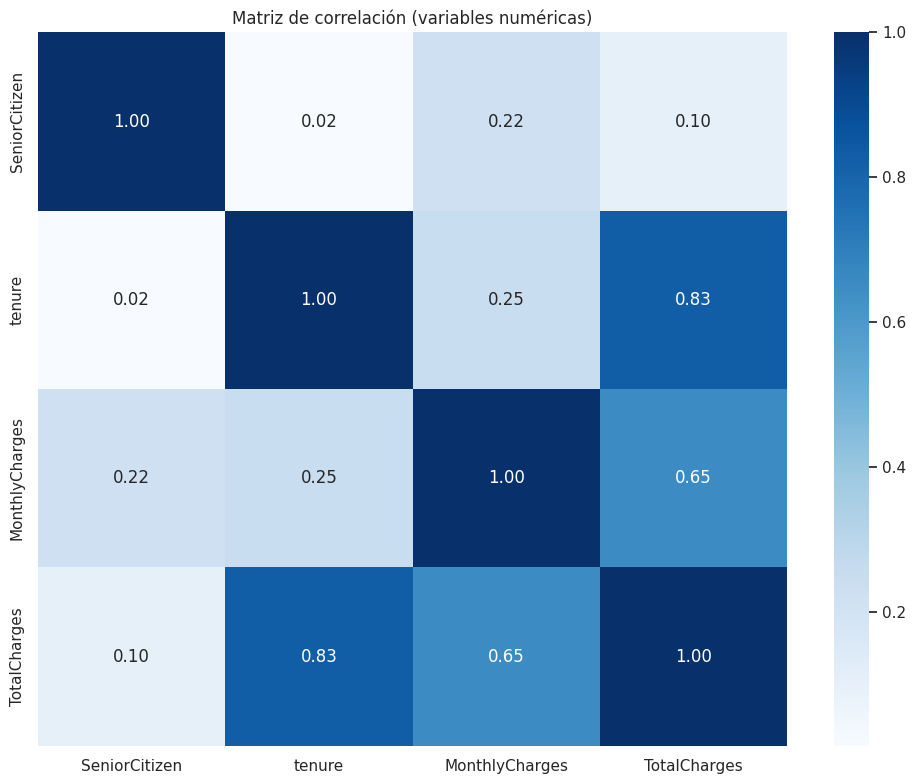

In [23]:
numeric_cols.append("TotalCharges")
if len(numeric_cols) > 0:
    plt.figure(figsize=(10, 8))
    corr_matrix = df[numeric_cols].corr()
    sns.heatmap(corr_matrix, annot=True, fmt=".2f", cmap="Blues")
    plt.title("Matriz de correlación (variables numéricas)")
    plt.tight_layout()
    plt.show()
else:
    print("No se encontraron columnas numéricas para calcular correlaciones.")

Podemos observar que `TotalCharges` está muy colineada con `tenure` y `MonthlyCharges`. Esto tiene sentido, pues cuanto más tiempo permanezca un cliente en la empresa (`tenure`), mayores serán sus `TotalCharges`. De igual manera, `TotalCharges` es esencialmente el producto entre `MonthlyCharges` y `tenure`. Este es un problema que debemos resolver antes de avanzar a la aplicación de modelos.

### Feature Selection

Quitaremos `CustomerID`, pues no sirve para detectar patrones ni aporta al modelo.

In [24]:
if "customerID" in df.columns:
    df = df.drop(columns=["customerID"])

Por otro lado, quitaremos `TotalCharges`, por su colinealidad entre `MonthlyCharges` y `tenure`. Esta acción esta justificada en que, aproximadamente, `TotalCharges = MonthlyCharges * tenure`, por lo que no perdemos demasiada información.

In [25]:
if "TotalCharges" in df.columns:
    df = df.drop(columns=["TotalCharges"])

### Separación train/test
Antes de continuar con la estandarización de variables y la corrección del desbalanceo en la variable objetivo, haremos el train/test split para evitar Data Leakage, generación de sesgos u overfitting.


In [26]:
df.shape

(7032, 40)

Debido a que tenemos 7032 datos, de acuerdo a las reglas del curso, haremos una división 80/20% de los datos. Usaremos `stratify=y` para conservar la desproporción de la columna `Churn` tanto en el grupo de entrenamiento como en el de testeo, para asegurar la presencia de la clase minoritaria en el entrenamiento.

In [27]:
X = df.drop(columns=['Churn'])
y = df['Churn']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

### Detección de desbalanceo en la variable objetivo

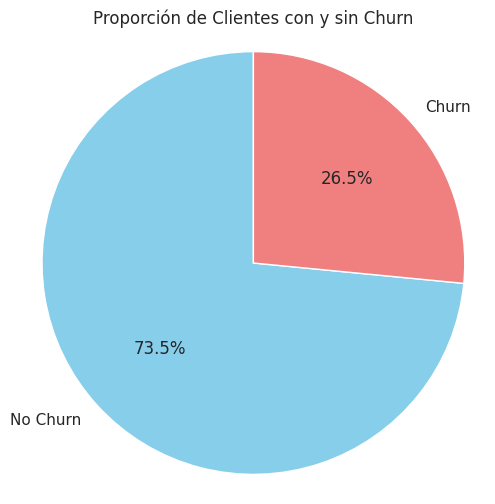

In [28]:
churn_proportions = distrib_churn['proporción']
churn_labels = ['No Churn', 'Churn']

plt.figure(figsize=(6, 6))
plt.pie(churn_proportions, labels=churn_labels, autopct='%1.1f%%', startangle=90, colors=['skyblue', 'lightcoral'])
plt.title('Proporción de Clientes con y sin Churn')
plt.axis('equal') # Equal aspect ratio ensures that pie is drawn as a circle.
plt.show()

Ya vimos que hay una desproporción en la variable objetivo `Churn`: hay más datos sobre los clientes que se quedaron que los que abandonaron, que son justamente el grupo de interés.

Para resolver esta problemática, aplicaremos SMOTE (Synthetic Minority Over-sampling Technique) para generar datos sintéticos de la clase minoritaria y balancear el DataSet.

El algoritmo `SMOTE` genera artificialmente nuevas instancias de la clase minoritaria utilizando los vecinos más cercanos de estos casos y submuestrea la clase mayoritaria para crear un conjunto de datos más equilibrado.

Aplicaremos SMOTE únicamente al grupo de entrenamiento, para evitar generar datos artificiales en el grupo de testeo.

In [29]:
smote = SMOTE(random_state=42)
X_train_smote, y_train_smote = smote.fit_resample(X_train, y_train)

In [30]:
y_train_smote.value_counts()

,count
Churn,
0,4130
1,4130


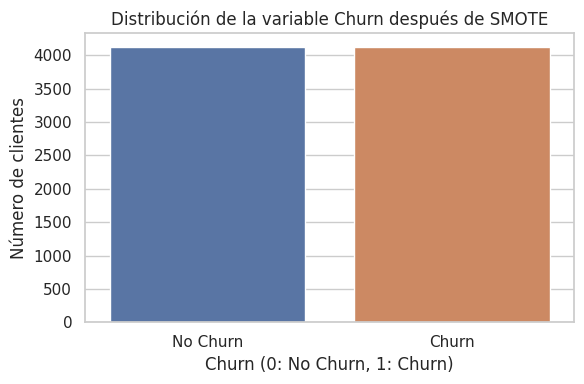

In [31]:
# Nueva distribución de Churn después de SMOTE
smote_counts = y_train_smote.value_counts().reset_index()
smote_counts.columns = ['Churn', 'count'] # Renombramos las columnas por claridad

plt.figure(figsize=(6, 4))
sns.barplot(x='Churn', y='count', data=smote_counts, hue="Churn", legend=False)
plt.title("Distribución de la variable Churn después de SMOTE")
plt.xlabel("Churn (0: No Churn, 1: Churn)")
plt.ylabel("Número de clientes")
plt.xticks(ticks=[0, 1], labels=['No Churn', 'Churn'])
plt.tight_layout()
plt.show()

Después de aplicar SMOTE, nuestro conjunto de entrenamiento ahora consta de una proporción igual de clientes actuales y que abandonaron.

### Estandarización de variables numéricas

Ahora que corregimos el desbalance de la variable objetivo en el grupo de entrenamiento, procederemos a normalizar las columnas numéricas que usaremos para los modelos de Machine Learning.

In [32]:
# Identificamos columnas numéricas para la normalización
numeric_cols_for_scaling = ['tenure', 'MonthlyCharges'] # Excluimos columnas binarias y de OHE

# Inicializamos el Scaler
scaler = StandardScaler()

# Ajustamos el Scaler solo en las columnas numéricas de los datos de entrenamiento (después de SMOTE)
scaler.fit(X_train_smote[numeric_cols_for_scaling])

# Transformamos ambas columnas numéricas de los datos de entrenamiento y prueba
X_train_scaled_numeric = scaler.transform(X_train_smote[numeric_cols_for_scaling])
X_test_scaled_numeric = scaler.transform(X_test[numeric_cols_for_scaling])

# Convierta de vuelta a DataFrames para conservar los nombres de las columnas
X_train_scaled_numeric_df = pd.DataFrame(X_train_scaled_numeric, columns=numeric_cols_for_scaling, index=X_train_smote.index)
X_test_scaled_numeric_df = pd.DataFrame(X_test_scaled_numeric, columns=numeric_cols_for_scaling, index=X_test.index)

# Quitamos columnas numéricas originales y concatenamos las escaladas
X_train_final = X_train_smote.drop(columns=numeric_cols_for_scaling).copy()
X_train_final[numeric_cols_for_scaling] = X_train_scaled_numeric_df

X_test_final = X_test.drop(columns=numeric_cols_for_scaling).copy()
X_test_final[numeric_cols_for_scaling] = X_test_scaled_numeric_df

## 5. Selección y comparación de modelos

Para este proyecto, elegimos los siguientes modelos: Logistic Regression, Random Forest, XGBoost, SVM y KNN.

In [33]:
# Función auxiliar de evaluación (mismas métricas para todos)
def evaluar_modelo(nombre, modelo, X_test, y_test, plot_curves=True):
    """
    Calcula métricas en el conjunto de prueba,
    muestra matriz de confusión y curva ROC,
    y devuelve un diccionario con las métricas.
    """
    y_pred = modelo.predict(X_test)

    # Probabilidades o scores para ROC-AUC
    if hasattr(modelo, "predict_proba"):
        y_proba = modelo.predict_proba(X_test)[:, 1]
    elif hasattr(modelo, "decision_function"):
        y_proba = modelo.decision_function(X_test)
    else:
        y_proba = None

    acc = accuracy_score(y_test, y_pred)
    prec = precision_score(y_test, y_pred)
    rec = recall_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    roc_auc = roc_auc_score(y_test, y_proba) if y_proba is not None else np.nan

    print(f"\n=== {nombre} ===")
    print(f"Accuracy : {acc:.4f}")
    print(f"Precision: {prec:.4f}")
    print(f"Recall   : {rec:.4f}")
    print(f"F1-score : {f1:.4f}")
    print(f"ROC-AUC  : {roc_auc:.4f}")

    # Matriz de confusión
    cm = confusion_matrix(y_test, y_pred)
    plt.figure(figsize=(4, 3))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
    plt.title(f"Matriz de confusión - {nombre}")
    plt.xlabel("Predicción")
    plt.ylabel("Real")
    plt.tight_layout()
    plt.show()

    # Curva ROC
    if plot_curves and (y_proba is not None):
        fpr, tpr, _ = roc_curve(y_test, y_proba)
        plt.figure(figsize=(4, 3))
        plt.plot(fpr, tpr, label=f"{nombre} (AUC = {roc_auc:.3f})")
        plt.plot([0, 1], [0, 1], "k--", label="Azar")
        plt.xlabel("1 - Especificidad (FPR)")
        plt.ylabel("Sensibilidad (TPR)")
        plt.title(f"Curva ROC - {nombre}")
        plt.legend()
        plt.tight_layout()
        plt.show()

    return {
        "Modelo": nombre,
        "Accuracy": acc,
        "Precision": prec,
        "Recall": rec,
        "F1": f1,
        "ROC_AUC": roc_auc
    }

# Definimos CV estratificado común para todos
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

### Logistic Regression (con Grid Search)

In [34]:
# Modelo base
log_reg = LogisticRegression(max_iter=1000, n_jobs=-1)

param_grid_lr = {
    "C": [0.01, 0.1, 1, 10],
    "penalty": ["l2"],
    "solver": ["lbfgs"]  # apropiado para muchas features
}

grid_lr = GridSearchCV(
    estimator=log_reg,
    param_grid=param_grid_lr,
    scoring="roc_auc",
    cv=cv,
    n_jobs=-1,
    verbose=1
)

grid_lr.fit(X_train_final, y_train_smote)

best_lr = grid_lr.best_estimator_
print("Mejores hiperparámetros LR:", grid_lr.best_params_)
print("Mejor ROC-AUC (CV) LR:", grid_lr.best_score_)

Fitting 5 folds for each of 4 candidates, totalling 20 fits
Mejores hiperparámetros LR: {'C': 10, 'penalty': 'l2', 'solver': 'lbfgs'}
Mejor ROC-AUC (CV) LR: 0.9299172182518511


### Random Forest (con Grid Search)

In [35]:
# Modelo base
rf = RandomForestClassifier(random_state=42, n_jobs=-1)

param_grid_rf = {
    "n_estimators": [100, 200],
    "max_depth": [None, 10, 20],
    "min_samples_split": [2, 5],
    "min_samples_leaf": [1, 2],
    "max_features": ["sqrt", "log2"]
}

grid_rf = GridSearchCV(
    estimator=rf,
    param_grid=param_grid_rf,
    scoring="roc_auc",
    cv=cv,
    n_jobs=-1,
    verbose=1
)

grid_rf.fit(X_train_final, y_train_smote)

best_rf = grid_rf.best_estimator_
print("Mejores hiperparámetros RF:", grid_rf.best_params_)
print("Mejor ROC-AUC (CV) RF:", grid_rf.best_score_)

Fitting 5 folds for each of 48 candidates, totalling 240 fits
Mejores hiperparámetros RF: {'max_depth': 20, 'max_features': 'log2', 'min_samples_leaf': 1, 'min_samples_split': 5, 'n_estimators': 200}
Mejor ROC-AUC (CV) RF: 0.9323905574869995


### XGBoost (con Randomized Search)

In [36]:
# Modelo base
xgb = XGBClassifier(
    objective="binary:logistic",
    eval_metric="logloss",
    use_label_encoder=False,
    random_state=42,
    n_jobs=-1
)

param_dist_xgb = {
    "n_estimators": [100, 200, 300],
    "max_depth": [3, 5, 7],
    "learning_rate": [0.01, 0.05, 0.1, 0.2],
    "subsample": [0.7, 0.8, 1.0],
    "colsample_bytree": [0.7, 0.8, 1.0]
}

rand_xgb = RandomizedSearchCV(
    estimator=xgb,
    param_distributions=param_dist_xgb,
    n_iter=30,                 # número de combinaciones a muestrear
    scoring="roc_auc",
    cv=cv,
    n_jobs=-1,
    random_state=42,
    verbose=1
)

rand_xgb.fit(X_train_final, y_train_smote)

best_xgb = rand_xgb.best_estimator_
print("Mejores hiperparámetros XGB:", rand_xgb.best_params_)
print("Mejor ROC-AUC (CV) XGB:", rand_xgb.best_score_)

Fitting 5 folds for each of 30 candidates, totalling 150 fits


/usr/local/lib/python3.12/dist-packages/xgboost/training.py:199: UserWarning: [13:37:59] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


Mejores hiperparámetros XGB: {'subsample': 0.8, 'n_estimators': 200, 'max_depth': 7, 'learning_rate': 0.05, 'colsample_bytree': 0.8}
Mejor ROC-AUC (CV) XGB: 0.937434703844192


### Support-Vector Machines (con Grid Search)

In [37]:
# Modelo base
svm = SVC(probability=True, random_state=42)

param_grid_svm = {
    "C": [0.1, 1, 10],
    "gamma": ["scale", 0.1, 0.01],
    "kernel": ["rbf"]
}

grid_svm = GridSearchCV(
    estimator=svm,
    param_grid=param_grid_svm,
    scoring="roc_auc",
    cv=cv,
    n_jobs=-1,
    verbose=1
)

grid_svm.fit(X_train_final, y_train_smote)

best_svm = grid_svm.best_estimator_
print("Mejores hiperparámetros SVM:", grid_svm.best_params_)
print("Mejor ROC-AUC (CV) SVM:", grid_svm.best_score_)

Fitting 5 folds for each of 9 candidates, totalling 45 fits
Mejores hiperparámetros SVM: {'C': 10, 'gamma': 0.01, 'kernel': 'rbf'}
Mejor ROC-AUC (CV) SVM: 0.9263453499756696


### N-Nearest Neighbors (con Grid Search)

In [38]:
# Modelo base
knn = KNeighborsClassifier()

param_grid_knn = {
    "n_neighbors": [3, 5, 7, 9],
    "weights": ["uniform", "distance"],
    "metric": ["minkowski"]   # con p=2 es la distancia Euclídea por defecto
}

grid_knn = GridSearchCV(
    estimator=knn,
    param_grid=param_grid_knn,
    scoring="roc_auc",
    cv=cv,
    n_jobs=-1,
    verbose=1
)

grid_knn.fit(X_train_final, y_train_smote)

best_knn = grid_knn.best_estimator_
print("Mejores hiperparámetros KNN:", grid_knn.best_params_)
print("Mejor ROC-AUC (CV) KNN:", grid_knn.best_score_)


Fitting 5 folds for each of 8 candidates, totalling 40 fits
Mejores hiperparámetros KNN: {'metric': 'minkowski', 'n_neighbors': 9, 'weights': 'distance'}
Mejor ROC-AUC (CV) KNN: 0.9116527622252578


## 6. Evaluación de modelos


=== Logistic Regression ===
Accuracy : 0.7775
Precision: 0.5735
Recall   : 0.6364
F1-score : 0.6033
ROC-AUC  : 0.8243


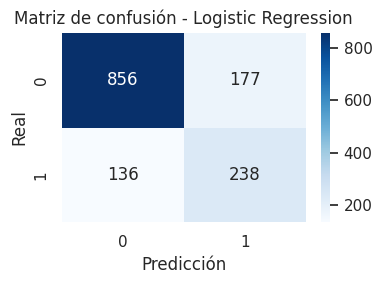

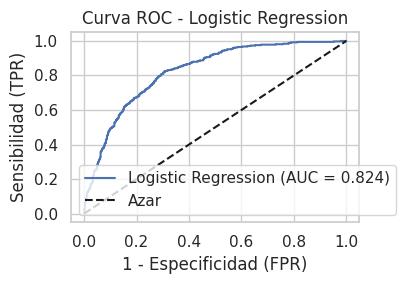


=== Random Forest ===
Accuracy : 0.7690
Precision: 0.5627
Recall   : 0.5882
F1-score : 0.5752
ROC-AUC  : 0.8070


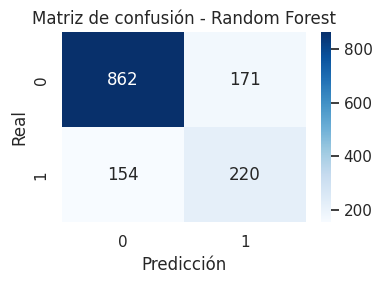

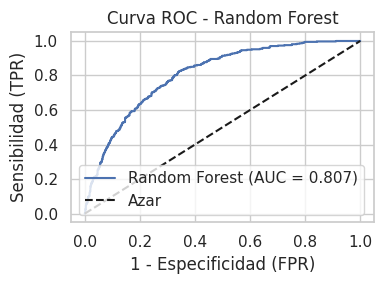


=== XGBoost ===
Accuracy : 0.7818
Precision: 0.5866
Recall   : 0.6070
F1-score : 0.5966
ROC-AUC  : 0.8181


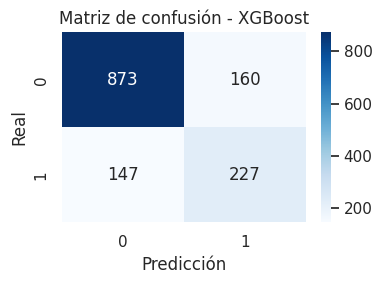

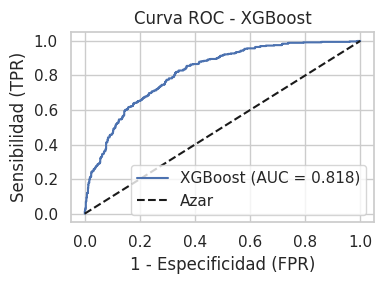


=== SVM ===
Accuracy : 0.7761
Precision: 0.5774
Recall   : 0.5882
F1-score : 0.5828
ROC-AUC  : 0.8053


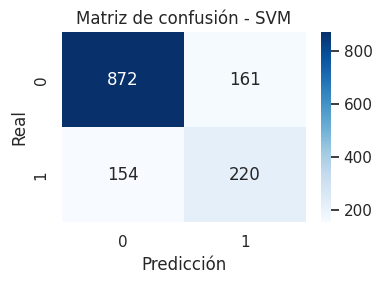

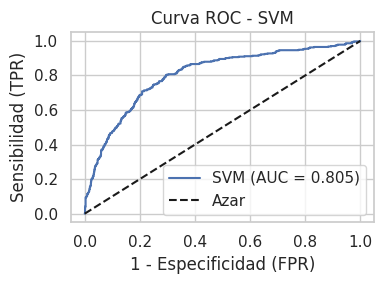


=== KNN ===
Accuracy : 0.7434
Precision: 0.5143
Recall   : 0.6257
F1-score : 0.5645
ROC-AUC  : 0.7863


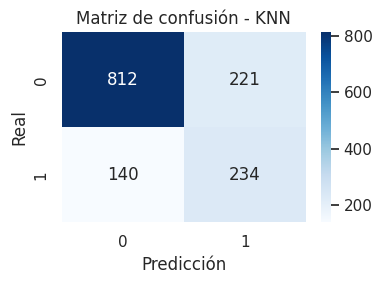

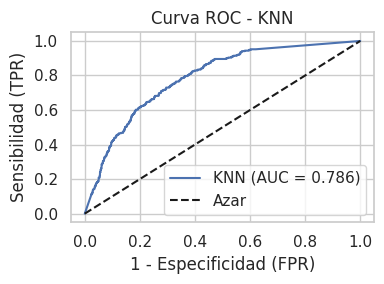

,Accuracy,Precision,Recall,F1,ROC_AUC
Modelo,,,,,
Logistic Regression,0.777541,0.573494,0.636364,0.603295,0.824297
XGBoost,0.781805,0.586563,0.606952,0.596583,0.818108
Random Forest,0.769012,0.562660,0.588235,0.575163,0.807006
SVM,0.776119,0.577428,0.588235,0.582781,0.805350
KNN,0.743426,0.514286,0.625668,0.564536,0.786343


In [39]:
resultados = []

# Evaluar cada modelo óptimo en X_test_final / y_test
resultados.append(evaluar_modelo("Logistic Regression", best_lr,  X_test_final, y_test))
resultados.append(evaluar_modelo("Random Forest",       best_rf,  X_test_final, y_test))
resultados.append(evaluar_modelo("XGBoost",             best_xgb, X_test_final, y_test))
resultados.append(evaluar_modelo("SVM",                 best_svm, X_test_final, y_test))
resultados.append(evaluar_modelo("KNN",                 best_knn, X_test_final, y_test))

# Tabla resumen
resultados_df = pd.DataFrame(resultados).set_index("Modelo")
display(resultados_df.sort_values("ROC_AUC", ascending=False))

Tomando la tabla anterior:

* Logistic Regression tiene `ROC-AUC = 0.824` (la más alta).

* XGBoost tiene `Accuracy = 0.782` (la más alta), `Precision = 0.587` (ligeramente mejor que LR) y `ROC-AUC = 0.818` (muy cercana pero algo menor que LR).

* Random Forest tiene métricas intermedias, con `Recall = 0.588` y `ROC-AUC = 0.808`.

* SVM es muy parecido a Random Forest, con el mismo Recall y `ROC-AUC = 0.805`.

* KNN tiene el peor rendimiento, con `Recall = 0.625` y `ROC-AUC = 0.786`.

Desde el punto de vista del negocio, nos interesa especialmente:

* Recall de la clase positiva (churn): nos interesan los falsos negativos, pues no queremos dejar muchos churners sin detectar.

* F1-Score: balance entre precision y recall.

* ROC-AUC: qué tan bien separa churners de no churners en términos globales.

Con este criterio, **Logistic Regression** tiene el mejor ROC-AUC y también el mejor Recall y F1. De igual manera, **XGBoost** gana por un poco en Accuracy y Precision, pero pierde algo en Recall y ROC-AUC.

Por último, Random Forest y SVM quedan un poco por detrás en todas las métricas, mientras que KNN no compite con los demás.

## 7. Interpretación del modelo

Primero, realizaremos la interpretación del mejor modelo: Logistic Regression. Gracias a ser un modelo lineal generalizado, los coeficientes de este modelo tienen una interpretación directa: cada coeficiente mide cuánto cambia el log-odds de churn cuando el predictor aumenta en 1 unidad.

### Log-odds en Logistic Regression

In [40]:
# Coeficientes y nombres de variables
coefs = best_lr.coef_[0]          # vector de coeficientes (clase positiva: churn)
features = X_train_final.columns  # nombres de columnas

coef_df = pd.DataFrame({
    "feature": features,
    "coef": coefs
})

# Valor absoluto para medir "fuerza" del efecto
coef_df["abs_coef"] = coef_df["coef"].abs()

# Ordenar por importancia (en valor absoluto)
coef_df_sorted = coef_df.sort_values("abs_coef", ascending=False)

# Ver las 20 features más influyentes
top_20 = coef_df_sorted.head(20)
display(top_20)

,feature,coef,abs_coef
4,PhoneService,-6.580368,6.580368
35,PaymentMethod_Electronic check,6.218109,6.218109
36,PaymentMethod_Mailed check,5.944957,5.944957
30,Contract_Month-to-month,5.750126,5.750126
34,PaymentMethod_Credit card (automatic),5.608280,5.608280
33,PaymentMethod_Bank transfer (automatic),5.588697,5.588697
7,MultipleLines_No phone service,-5.297526,5.297526
31,Contract_One year,4.912609,4.912609
32,Contract_Two year,4.391972,4.391972
9,InternetService_DSL,-4.284589,4.284589


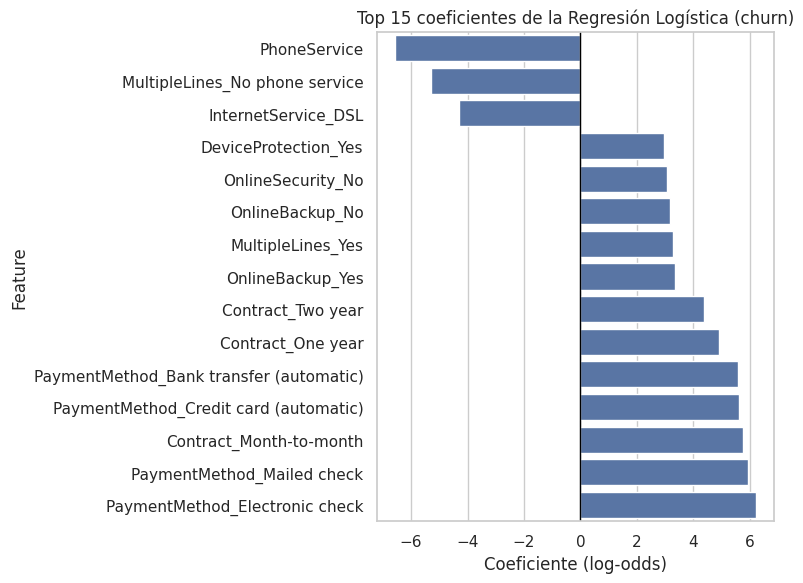

In [41]:
top_n = 15
top_n_coefs = coef_df_sorted.head(top_n).copy()
top_n_coefs = top_n_coefs.sort_values("coef")  # para que quede ordenado en el eje y

plt.figure(figsize=(8, 6))
sns.barplot(
    data=top_n_coefs,
    x="coef",
    y="feature",
    orient="h"
)
plt.axvline(0, color="black", linewidth=1)
plt.title("Top 15 coeficientes de la Regresión Logística (churn)")
plt.xlabel("Coeficiente (log-odds)")
plt.ylabel("Feature")
plt.tight_layout()
plt.show()


Podemos ver que:
* `PaymentMethod_Electronic check` es el coeficiente más grande y positivo: los clientes que pagan con cheque electrónico tienen mucho mayor probabilidad de churn que los que usan otros métodos.
* `PaymentMethod_Mailed check` y los métodos automáticos (`PaymentMethod_Bank transfer (automatic)` y `PaymentMethod_Credit card (automatic)`) también aumenta el riesgo, aunque algo menos.
* `Contract_Month-to-month` tiene el coeficiente positivo más alto: los contratos mes a mes elevan el riesgo de churn frente a los contratos de mayor duración.
* `OnlineSecurity_No` y `OnlineBackup_No` tienen coeficientes positivos: no contar con seguridad online ni respaldo se asocia a mayor probabilidad de abandono.
* `InternetService_DSL` aparece con coeficiente negativo: en comparación con la categoría de referencia (por ejemplo, fibra óptica), DSL presenta menor riesgo de churn, lo que es consistente con lo que vimos en el EDA (la fibra tenía más abandonos).
* `PhoneService` tienen coeficiente negativo: disponer de servicio telefónico parece disminuir el riesgo de churn.
* `MultipleLines_No phone service` también tiene coeficiente negativo: no disponer de servicio telefónico parece disminuir el riesgo de churn, aunque algo menos.
  * Esta conclusión, un tanto contradictoria, puede deberse a la colinealidad no detectada entre `PhoneService` y `MultipleLines_No phone service`. En el dataset original, si `PhoneService = "No"`, entonces `MultipleLines = "No phone service"`, es decir, esas dos columnas están fuertemente ligadas: una casi determina a la otra.

### SHAP values

In [42]:
shap.initjs()

# Diccionario con los modelos entrenados en la parte 5
# Ajusta los nombres de los objetos si en tu notebook son distintos
modelos_entrenados = {
    "LogisticRegression": best_lr,
    "RandomForest": best_rf,
    "XGBoost": best_xgb,
    "SVM": best_svm,
    "KNN": best_knn
}

# Aquí indicamos manualmente el nombre del modelo campeón según la tabla de la parte 6
nombre_modelo_campeon = "LogisticRegression"  # <-- CAMBIA ESTO si tu campeón es otro

modelo_campeon = modelos_entrenados[nombre_modelo_campeon]
modelo_campeon


LogisticRegression(C=10, max_iter=1000, n_jobs=-1)

In [43]:
# Creamos el explicador para el modelo campeón
explainer_campeon = shap.Explainer(modelo_campeon, X_train_final)

# Calculamos SHAP values en el set de prueba
shap_values_campeon = explainer_campeon(X_test_final)

shap_values_campeon.shape


(1407, 39)

In [44]:
shap.initjs()

# Modelo campeón: regresión logística
modelo_campeon = best_lr

# 1) Explainer lineal clásico
explainer_lr = shap.LinearExplainer(modelo_campeon, X_train_final)

# 2) Valores SHAP sobre el set de prueba (forzamos ndarray float)
shap_values_lr_raw = explainer_lr.shap_values(X_test_final)

shap_values_lr = np.asarray(shap_values_lr_raw, dtype="float64")
X_test_np = X_test_final.to_numpy(dtype="float64")

print("shape SHAP:", shap_values_lr.shape)
print("shape X_test:", X_test_np.shape)


shape SHAP: (1407, 39)
shape X_test: (1407, 39)


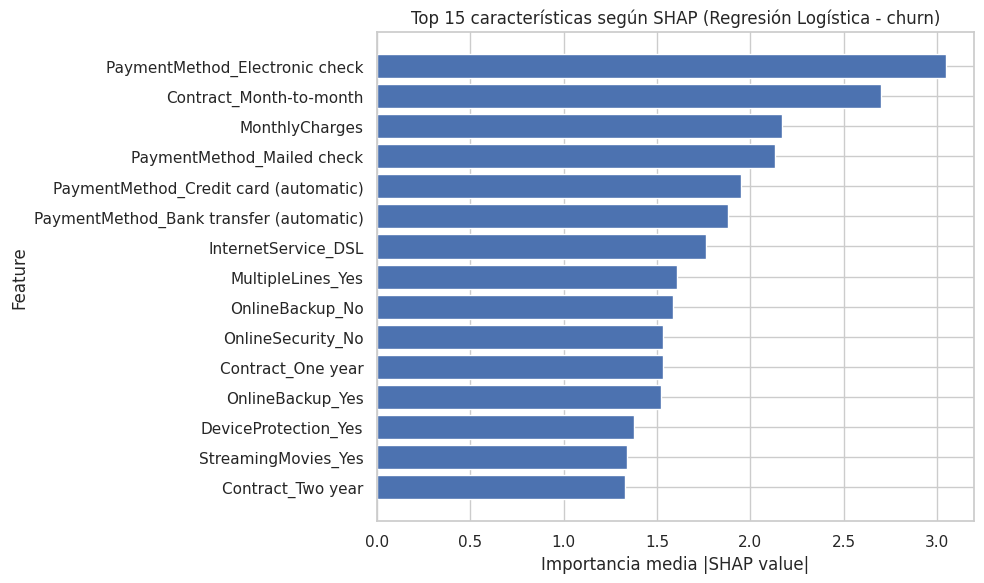

In [45]:
# Importancia global: media del valor absoluto de SHAP por feature
mean_abs_shap = np.mean(np.abs(shap_values_lr), axis=0)

shap_importance_df = pd.DataFrame({
    "Feature": X_train_final.columns,
    "mean_abs_shap": mean_abs_shap
}).sort_values("mean_abs_shap", ascending=False)

top_n = 15
top_shap = shap_importance_df.head(top_n)

plt.figure(figsize=(10, 6))
plt.barh(top_shap["Feature"][::-1], top_shap["mean_abs_shap"][::-1])
plt.xlabel("Importancia media |SHAP value|")
plt.ylabel("Feature")
plt.title("Top 15 características según SHAP (Regresión Logística - churn)")
plt.tight_layout()
plt.show()


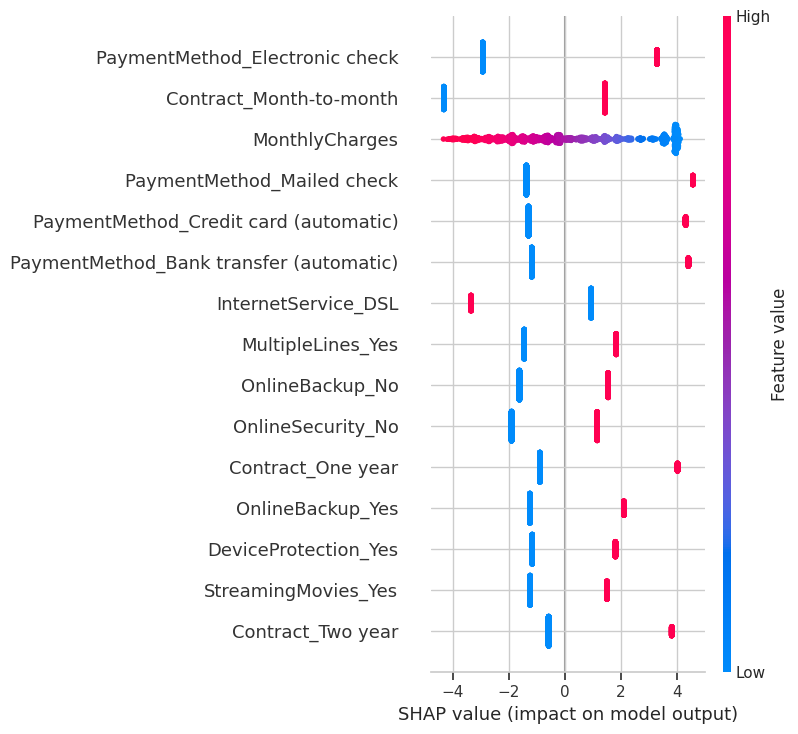

In [46]:
shap.summary_plot(
    shap_values_lr,      # ndarray (n_muestras, n_features)
    X_test_np,           # ndarray (n_muestras, n_features)
    feature_names=X_test_final.columns.tolist(),
    max_display=15
)


El summary plot de SHAP revela las variables más influyentes en las predicciones de churn, destacando:

- PaymentMethod_Electronic check

- Contract_Month-to-month

- MonthlyCharges

- PaymentMethod_Mailed check

- Métodos de pago automáticos (Credit card y Bank transfer)

- Variables asociadas a la ausencia de servicios adicionales, como OnlineSecurity_No, OnlineBackup_No, TechSupport_No, etc.

- El tipo de contrato a uno o dos años (Contract_One year, Contract_Two year).

El patrón de colores en el summary plot proporciona información cualitativa sobre el efecto de cada variable:

- Para PaymentMethod_Electronic check, los clientes que usan este método (puntos rojos) tienden a tener valores SHAP positivos, indicando que este método de pago empuja las predicciones hacia el churn. Quienes no lo usan (puntos azules) tienen SHAP negativos, reduciendo el riesgo.

- En Contract_Month-to-month se observa una tendencia similar: el contrato mes a mes (True) se asocia con valores SHAP positivos, lo que aumenta la probabilidad estimada de abandono. Los contratos a uno o dos años, en cambio, presentan valores SHAP mayormente negativos, estabilizando la permanencia.

- Los métodos de pago automático (PaymentMethod_Credit card (automatic) y PaymentMethod_Bank transfer (automatic)) muestran el patrón opuesto: su uso genera SHAP negativos, sugiriendo que los pagos automatizados están asociados a un menor churn.

- Para las variables de servicios adicionales (OnlineSecurity_No, OnlineBackup_No, TechSupport_No, etc.), la ausencia de estos servicios se asocia con valores SHAP positivos, empujando hacia churn, mientras que disponer de ellos tiende a reducir la probabilidad de abandono. Esto sugiere que los clientes con más servicios tienden a estar más "anclados" a la compañía.

En resumen, el summary plot confirma que el modelo ha aprendido un perfil de alto riesgo coherente: clientes con contrato mes a mes, que pagan con métodos manuales (especialmente “electronic check”) y que no contratan ciertos servicios adicionales aportan sistemáticamente a aumentar el riesgo de churn.

Los gráficos SHAP permiten concluir que el modelo campeón ha aprendido un patrón coherente con la intuición de negocio:

- Los métodos de pago manuales (especialmente Electronic check) y los contratos mes a mes son factores clave que aumentan el riesgo de churn.

- Los clientes nuevos (bajo tenure) y con cargos mensuales relativamente bajos presentan mayores probabilidades de abandono.

- La contratación de servicios adicionales y el uso de métodos de pago automáticos tienden a reducir el churn.

Esta interpretación respalda las conclusiones del proyecto y sugiere acciones de retención: por ejemplo, incentivar la migración desde contratos mes a mes a contratos de mayor plazo, promover métodos de pago automáticos y diseñar campañas específicas para clientes nuevos con planes de bajo costo.

## 8. Conclusiones y recomendaciones

En este proyecto se abordó el problema de churn en telecomunicaciones como una tarea de clasificación binaria supervisada usando el dataset Telco Customer Churn. El objetivo fue construir modelos capaces de estimar, para cada cliente, la probabilidad de abandonar la compañía a partir de sus características demográficas, tipo de contrato, servicios contratados, comportamiento de pago y antigüedad, entre otros. Además de predecir, se buscó interpretar el modelo para identificar factores de riesgo y entregar recomendaciones concretas a las áreas comerciales y de retención.

El análisis exploratorio mostró un dataset desbalanceado, con muchos más clientes que permanecen que clientes que se van, lo que justificó el uso de SMOTE en el conjunto de entrenamiento. Otros hallazgos fueron:
* `MonthlyCharges` exhibe una gama amplia de precios con una gran masa en el plan mínimo.
* `tenure` presenta una estructura en “U”, con riesgo aparentemente bajo en los primeros meses.

Al analizar la "tasa de churn por categoría" se detectaron patrones claros:
* Contratos Month-to-month concentran gran parte del churn.
* Los métodos de pago manuales (especialmente Electronic check) se asocian a abandono elevado.
* Pagos automáticos y contratos de 1 ó 2 años parecen estabilizar la relación.
* La ausencia de servicios adicionales como OnlineSecurity, OnlineBackup y TechSupport también se relaciona con mayor churn.

En preprocesamiento, se detectó una fuerte colinealidad entre `TotalCharges`, `tenure` y `MonthlyCharges`, de modo que se optó por remover `TotalCharges` para no afectar a los modelos lineales.

Sobre estos datos, se entrenaron y ajustaron Logistic Regression, Random Forest, XGBoost, SVM y KNN. La comparación en el conjunto de prueba mostró que la regresión logística alcanzó el mejor ROC-AUC y los mejores valores de Recall y F1, mientras que XGBoost tuvo la mayor Accuracy pero con un leve deterioro en Recall. Random Forest y SVM quedaron en un nivel intermedio, y KNN fue claramente inferior, por lo que se escogió Logistic Regression como modelo campeón por su equilibrio entre desempeño e interpretabilidad.

La interpretación del modelo campeón combinó el análisis de coeficientes con SHAP. Los coeficientes y el ranking de importancia señalaron como factores clave de riesgo:
* Pagar con Electronic check o Mailed check.
* Estar en contrato Month-to-month
* Carecer de servicios adicionales (OnlineSecurity_No, OnlineBackup_No, TechSupport_No).
En contraste, los contratos de uno y dos años y los métodos de pago automáticos actúan como factores protectores.


El summary plot de SHAP confirmó que, en particular, los clientes nuevos y con baja `tenure` muestran contribuciones positivas (mayor riesgo a churn), mientras que los de larga permanencia aportan contribuciones negativas (menor riesgo a churn). Observemos que esta última conclusión se opone a lo observado durante el análisis exploratorio, lo cual no está necesariamente mal; está describiendo lo que nuestro modelo aprendió después de ajustar por todas las demás variables.

Desde la perspectiva de negocio, los resultados permiten priorizar acciones. Los clientes con contrato mensual, métodos de pago manuales, baja antigüedad y sin servicios adicionales conforman un segmento de alto riesgo que debería ser objetivo de campañas de retención específicas: ofrecer incentivos para migrar a contratos de mayor plazo, promover la adopción de pagos automáticos y empaquetar servicios de seguridad/soporte. Los clientes con tenure alto, contratos de dos años, servicios adicionales y pagos automáticos constituyen un segmento de bajo riesgo más adecuado para estrategias de fidelización y expansión de planes (por ejemplo, ofrecerle más servicios de los que tiene).

Pensando en trabajos futuros, podríamos profundizar el proyecto en varias direcciones: probar más estrategias de feature engineering, como variables de uso, cambios de plan en el tiempo o indicadores de reclamos, así como explorar modelos más complejos, por ejemplo, redes neuronales y gradient boosting avanzado. Asimismo, podría revisarse medidas para mitigar la colinealidad entre `PhoneService` y `MultipleLines_No phone service` detectada al final del trabajo.

En conjunto, el proyecto demuestra que un flujo de trabajo de Machine Learning bien diseñado (desde el EDA y el preprocesamiento hasta la comparación de modelos y la interpretación con SHAP) no solo permite predecir quién tiene mayor probabilidad de churn, sino también entender por qué, entregando insumos concretos para diseñar estrategias de retención efectivas y focalizadas.

